In [1]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv("D:\datasets\Hourly Energy Consumption\PJME_hourly.csv")
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


lets first change the index to the datetime 

In [4]:
data = data.set_index("Datetime")
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


the datetime is object lets change to datetime 

In [5]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


nice!! now lets plot the data we have and know what type of data we working with 

<AxesSubplot:title={'center':'PJME Hourly Energy Consumption'}, xlabel='Datetime'>

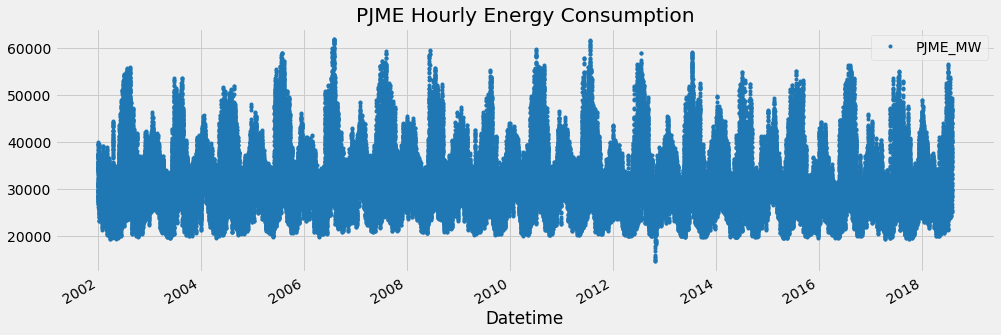

In [6]:
data.plot(style=".", figsize=(15, 5), color=color_pal[0], title="PJME Hourly Energy Consumption")

seems we working with seasonal pattern

# Train / Test Split

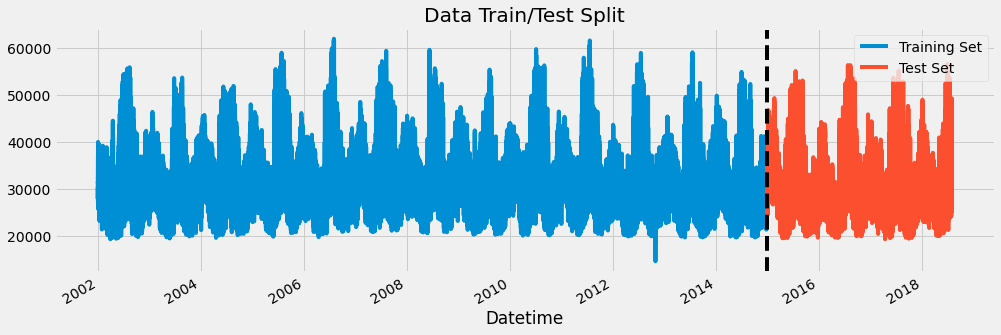

In [7]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# plotting only one week from the data 

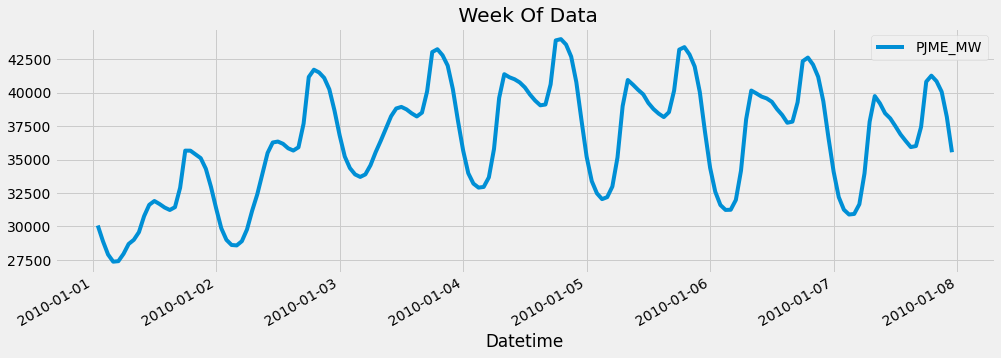

In [8]:
data.loc[(data.index > "01-01-2010") & (data.index < "01-08-2010")] \
    .plot(figsize=(15, 5), title=" Week Of Data")
plt.show()

# Feature Creation

In [9]:
def creat(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

data = creat(data)


In [10]:
# lets see the data 
data.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


# Visualize our Feature / Target Relationship

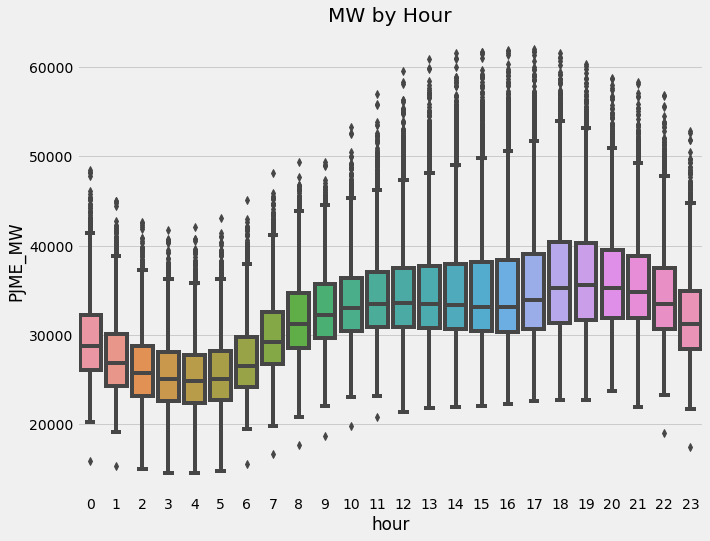

In [11]:
# plot by hour 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

note: it inceases at first houers then it drops when all go to work school and more and it come back to increase more at the night and it decreases when all get to sleep 

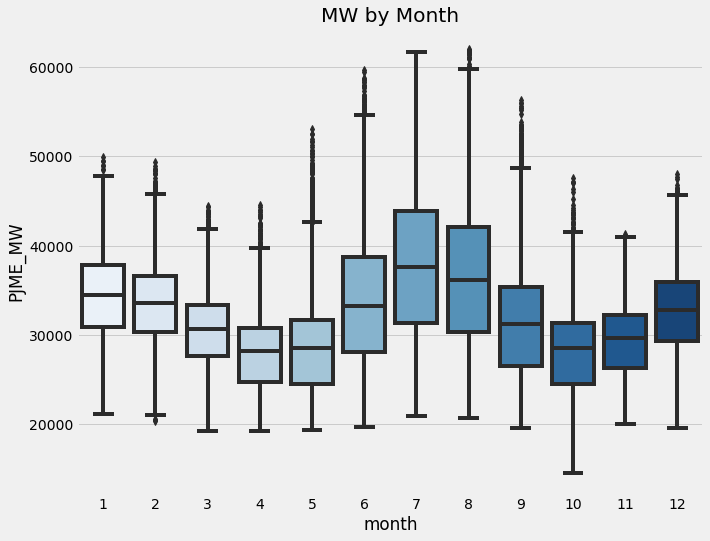

In [12]:
# plot by month 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

note: of course it increas when all people using their AC in summer days

# Create our Model

In [13]:
train = creat(train)
test = creat(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
import xgboost as xgb 

In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:21:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

# Feature Importance

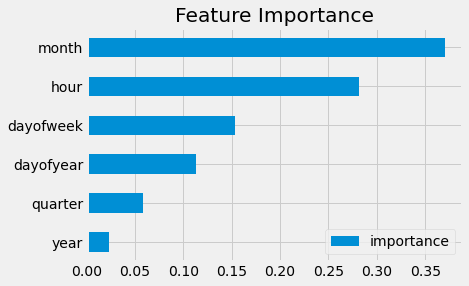

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show() 

# Forecast on Test

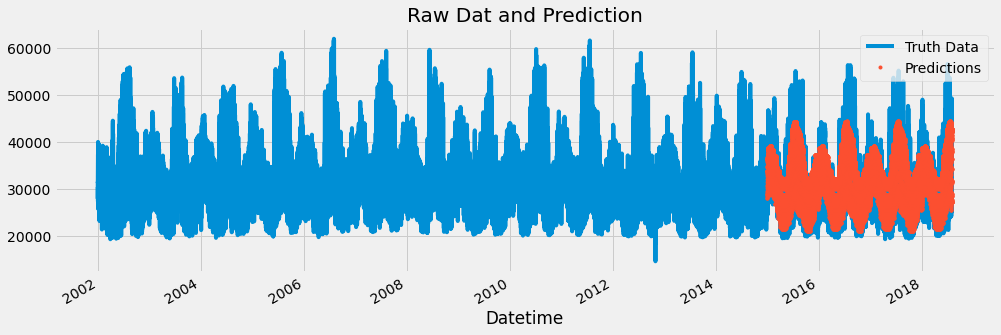

In [18]:
test['prediction'] = reg.predict(X_test)
df = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

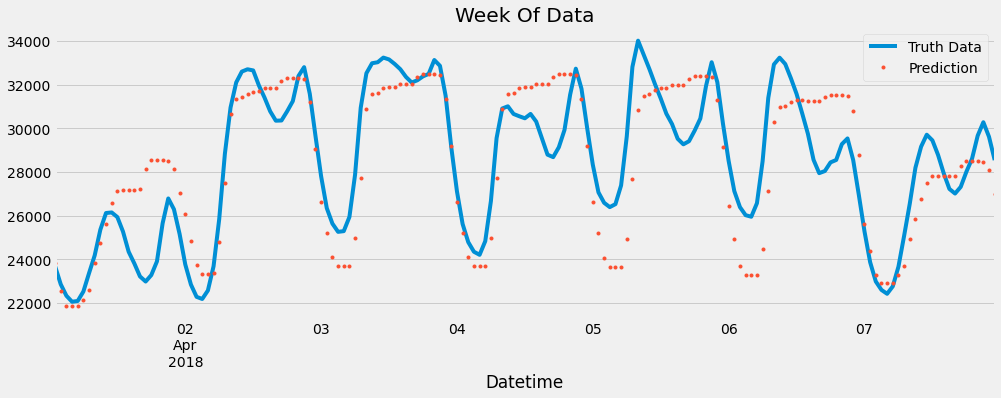

In [19]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

note: as we all see the model needes a lot of adjusting but it is simple model 

# Score (RMSE)

In [20]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


# Calculate Error

In [21]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

note: those dates are the model got them wrong 